# Percentage Based - Outline

This notebook contains four different machine learning algorithms trained to predict win probabilities of basketball matchups:

*   Logistic Regression
*   Naive Bayes
*   Random Forest Regressor and Random Forest Classifier
*   Neural Network




In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%tensorflow_version 2.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split #for train_test_split
import tensorflow as tf #import tensorflow
from tensorflow.keras import layers, optimizers #import tensorflow
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
print(tf.__version__)


2.2.0-rc3


In [104]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Calculating Win Percentage
As a first step, we calculate the win loss percentage of each time over all seasons

In [105]:
#@title get win-loss records
teams = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeams.csv")
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season_compact = season_compact[season_compact['Season'] > 2002]
teams.drop(columns=['TeamName', 'FirstD1Season', 'LastD1Season'], inplace=True)

teams['Season'] = 2003
teams_copy = teams.copy()

for i in range(2004, 2020):
  temp = pd.DataFrame()
  temp['TeamID'] = teams_copy['TeamID']
  temp['Season'] = i
  teams = pd.concat((teams, temp))


def win_percentages(teams, games):
  teams['W'] = 0
  teams['L'] = 0
  for index, game in games.iterrows():
    teams.at[(game['WTeamID'], game['Season']), 'W'] = teams.loc[(game['WTeamID'], game['Season']), 'W'] + 1
    teams.at[(game['LTeamID'], game['Season']), 'L'] = teams.loc[(game['LTeamID'], game['Season']), 'L'] + 1

  teams['WP'] = teams['W'] / (teams['W'] + teams['L'])
  return teams.dropna()

teams.set_index(['TeamID', 'Season'], inplace=True)
teams = win_percentages(teams, season_compact)

teams

,,W,L,WP
TeamID,Season,,,
1102,2003,12,16,0.428571
1103,2003,13,14,0.481481
1104,2003,17,11,0.607143
1105,2003,7,19,0.269231
1106,2003,13,15,0.464286
...,...,...,...,...
1462,2019,18,15,0.545455
1463,2019,21,7,0.750000
1464,2019,10,20,0.333333


#Calculate game efficiency and percentage stats
For this, we aggregate each team's stats by their season

In [106]:
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv")

#get aggregated stats for games teams won
season_details_winners = season[[ 'WTeamID','Season', 'WScore', 'LScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_winners.columns = [ 'WTeamID','Season', 'Points', 'PointsAllowed',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

#calculate percentages
season_details_winners = season_details_winners.rename(columns={"WTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()
season_details_winners.reset_index(inplace=True)

#get aggregated stats for games teams lost
season_details_losers = season[[ 'LTeamID','Season', 'LScore', 'WScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_losers.columns = ['LTeamID','Season', 'Points', 'PointsAllowed',
       'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 
       'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF']

#calculate percentages
season_details_losers = season_details_losers.rename(columns={"LTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()

season_details_losers.reset_index(inplace=True)

season_details = pd.concat((season_details_winners, season_details_losers))


season_details = season_details.groupby(['TeamID', 'Season']).sum().reset_index()

season_details.columns = ['TeamID', 'Season', 'Points','PointsAllowed','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF']

def calculate_percentages(teams): 
  teams['FTPercentage'] = teams['FTM'] / teams['FTA']
  teams['3PAttemptRate'] = teams['FGA3'] / (teams['FGA'] + teams['FGA3'])
  teams['ReboundPercentage'] = (teams['OR'] + teams['DR']) / (teams['OOR'] + teams['ODR'] + teams['OR'] + teams['DR'])
  teams['AssistPercentage'] = teams['Ast'] / (teams['FGM'] + teams['FGM3'])
  o_possessions = (teams['FGA'] - teams['OR'] 
            + teams['TO'] + (0.475 * teams['FTA']))
  d_possessions = (teams['OFGA'] - teams['OOR'] 
            + teams['OTO'] + (0.475 * teams['OFTA']))
  teams['Off-Efficiency'] = 100 * (teams['Points'] / o_possessions)
  teams['Def-Efficiency'] = 100 * (teams['PointsAllowed'] / d_possessions)
  teams['Net-Efficiency'] = teams['Off-Efficiency'] - teams['Def-Efficiency']
  teams['Pace'] = (o_possessions + d_possessions / (2 * (40/5))) / 20
  teams['OffRebPercentage'] = (teams['OR']) / (teams['OOR'] + teams['ODR'] + teams['OR'] + teams['DR'])
  teams['TSP'] = teams['Points'] / ((2 * (teams['FGA'] + teams['FGA3'])) + (0.88 * teams['FTM']))
  teams['EFG'] = (teams['FGM'] + (0.5 * teams['FGM3'])) / (teams['FGA'] + teams['FGA3'])

  teams = teams[['TeamID', 'Season', 'TO', 'FTPercentage', '3PAttemptRate', 
        'ReboundPercentage', 'AssistPercentage',  'Net-Efficiency', 'Pace',
        'OffRebPercentage', 'TSP', 'EFG']]

  return teams


season_details = calculate_percentages(season_details)

season_details = season_details.merge(teams, how="left", on=['TeamID', 'Season']).drop(columns=['W', 'L'])

season_details


,TeamID,Season,TO,FTPercentage,3PAttemptRate,ReboundPercentage,AssistPercentage,Net-Efficiency,Pace,OffRebPercentage,TSP,EFG,WP
0,1101,2014,315,0.746067,0.262605,0.451099,0.370370,-22.608069,74.995156,0.127369,0.421198,0.348039,0.095238
1,1101,2015,359,0.727924,0.265973,0.437045,0.413450,-16.006540,96.145313,0.129267,0.396619,0.347449,0.250000
2,1101,2016,362,0.706985,0.259033,0.475890,0.420290,-7.817438,99.729219,0.126866,0.439095,0.374300,0.333333
3,1101,2017,362,0.642241,0.263536,0.460375,0.431472,-6.757561,91.721953,0.114338,0.437119,0.386464,0.360000
4,1101,2018,389,0.704365,0.261143,0.479890,0.434028,-2.646789,101.459609,0.134435,0.429691,0.376211,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,1464,2017,385,0.673394,0.252310,0.468472,0.408181,-9.791141,128.166328,0.135408,0.408674,0.366915,0.343750
5830,1464,2018,427,0.631387,0.254440,0.500943,0.384840,-14.798037,117.122109,0.195283,0.398397,0.355019,0.200000
5831,1464,2019,394,0.696833,0.305566,0.509651,0.374542,-7.984947,112.841562,0.178768,0.382213,0.345035,0.333333
5832,1465,2019,325,0.768763,0.299407,0.504269,0.304636,0.422811,97.336484,0.139808,0.416073,0.361251,0.461538


In [107]:
#title aggregate wins and losses with stats for each team
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season_compact = season_compact[season_compact['Season'] > 2002]
season_compact['Season'] = season_compact['Season'].astype(str)

season_details['Season'] = season_details['Season'].astype(str)
season_details['TeamID'] = season_details['TeamID'].astype(str)

season_compact['Season'] = season_compact['Season'].astype(str)
season_compact['WTeamID'] = season_compact['WTeamID'].astype(str)
season_compact['LTeamID'] = season_compact['LTeamID'].astype(str)

season_compact = season_compact.merge(season_details, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(season_details, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])

season_details_wins = pd.DataFrame()
season_details_wins['Season'] = season_compact['Season']
season_details_wins['DayNum'] = season_compact['DayNum']
season_details_wins['WTeamID'] = season_compact['WTeamID']
season_details_wins['LTeamID'] = season_compact['LTeamID']

season_details_wins['TO'] = season_compact['TO_x'] - season_compact['TO_y']
season_details_wins['FTPercentage'] = season_compact['FTPercentage_x'] - season_compact['FTPercentage_y']
season_details_wins['3PAttemptRate'] = season_compact['3PAttemptRate_x'] - season_compact['3PAttemptRate_y']
season_details_wins['ReboundPercentage'] = season_compact['ReboundPercentage_x'] - season_compact['ReboundPercentage_y']
season_details_wins['AssistPercentage'] = season_compact['AssistPercentage_x'] - season_compact['AssistPercentage_y']

season_details_wins['Pace'] = season_compact['Pace_x'] - season_compact['Pace_y']
season_details_wins['Net-Efficiency'] = season_compact['Net-Efficiency_x'] - season_compact['Net-Efficiency_y']

season_details_wins['OffRebPercentage'] = season_compact['OffRebPercentage_x'] - season_compact['OffRebPercentage_y']
season_details_wins['TSP'] = season_compact['TSP_x'] - season_compact['TSP_y']
season_details_wins['EFG'] = season_compact['EFG_x'] - season_compact['EFG_y']
season_details_wins['WP'] = season_compact['WP_x'] - season_compact['WP_y']

season_details_wins['Result'] = 1

season_details_loss = pd.DataFrame()
season_details_loss['Season'] = season_compact['Season']
season_details_loss['DayNum'] = season_compact['DayNum']
season_details_loss['WTeamID'] = season_compact['WTeamID']
season_details_loss['LTeamID'] = season_compact['LTeamID']

season_details_loss['TO'] = season_compact['TO_y'] - season_compact['TO_x']
season_details_loss['FTPercentage'] = season_compact['FTPercentage_y'] - season_compact['FTPercentage_x']
season_details_loss['3PAttemptRate'] = season_compact['3PAttemptRate_y'] - season_compact['3PAttemptRate_x']
season_details_loss['ReboundPercentage'] = season_compact['ReboundPercentage_y'] - season_compact['ReboundPercentage_x']
season_details_loss['AssistPercentage'] = season_compact['AssistPercentage_y'] - season_compact['AssistPercentage_x']
season_details_loss['Pace'] = season_compact['Pace_y'] - season_compact['Pace_x']
season_details_loss['Net-Efficiency'] = season_compact['Net-Efficiency_y'] - season_compact['Net-Efficiency_x']
season_details_loss['OffRebPercentage'] = season_compact['OffRebPercentage_y'] - season_compact['OffRebPercentage_x']
season_details_loss['TSP'] = season_compact['TSP_y'] - season_compact['TSP_x']
season_details_loss['EFG'] = season_compact['EFG_y'] - season_compact['EFG_x']
season_details_loss['WP'] = season_compact['WP_y'] - season_compact['WP_x']

season_details_loss['Result'] = 0

season_pred = pd.concat((season_details_wins, season_details_loss))

season_pred



,Season,DayNum,WTeamID,LTeamID,TO,FTPercentage,3PAttemptRate,ReboundPercentage,AssistPercentage,Pace,Net-Efficiency,OffRebPercentage,TSP,EFG,WP,Result
0,2003,10,1104,1328,18,0.002012,0.006551,-0.002855,-0.034435,-4.299141,-11.513942,0.017469,-0.023192,-0.030838,-0.192857,1
1,2003,10,1272,1393,5,-0.039816,0.047466,0.007217,0.065482,-3.263828,-1.303620,0.004689,-0.039701,-0.036250,-0.034483,1
2,2003,11,1266,1437,-101,0.057471,-0.031063,0.015121,0.079774,-12.115781,12.174933,-0.010656,0.069078,0.060738,0.321429,1
3,2003,11,1296,1457,117,0.016976,-0.026903,0.032778,0.012091,8.647969,-4.643379,0.027137,0.037350,0.031119,-0.094470,1
4,2003,11,1400,1208,64,0.000674,-0.011048,0.042850,-0.080668,4.457344,4.934478,0.036431,-0.006278,-0.012603,0.082011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,1153,1222,28,-0.002601,0.051684,0.010454,-0.011465,3.745234,7.225519,-0.022858,-0.016233,-0.003344,0.088235,0
87500,2019,132,1209,1426,77,0.081268,-0.015482,0.058571,0.079776,-1.968984,-6.281915,0.043211,-0.035501,-0.043886,-0.218750,0
87501,2019,132,1277,1276,-137,-0.052281,0.012406,-0.060312,-0.112242,-6.539687,-1.150777,-0.029287,-0.047296,-0.033531,0.000000,0
87502,2019,132,1387,1382,-24,0.144385,0.003265,-0.038834,-0.032554,-4.432656,-0.864902,-0.045830,0.002610,0.009758,-0.127731,0


In [0]:
#@title scale inputs
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

season_pred['TO'] = scaler.fit_transform(season_pred['TO'].values.reshape(-1,1))
season_pred['FTPercentage'] = scaler.fit_transform(season_pred['FTPercentage'].values.reshape(-1,1))
season_pred['3PAttemptRate'] = scaler.fit_transform(season_pred['3PAttemptRate'].values.reshape(-1,1))
season_pred['ReboundPercentage'] = scaler.fit_transform(season_pred['ReboundPercentage'].values.reshape(-1,1))
season_pred['AssistPercentage'] = scaler.fit_transform(season_pred['AssistPercentage'].values.reshape(-1,1))
season_pred['Pace'] = scaler.fit_transform(season_pred['Pace'].values.reshape(-1,1))

season_pred['Net-Efficiency'] = scaler.fit_transform(season_pred['Net-Efficiency'].values.reshape(-1,1))
season_pred['OffRebPercentage'] = scaler.fit_transform(season_pred['OffRebPercentage'].values.reshape(-1,1))
season_pred['TSP'] = scaler.fit_transform(season_pred['TSP'].values.reshape(-1,1))
season_pred['EFG'] = scaler.fit_transform(season_pred['EFG'].values.reshape(-1,1))
season_pred['WP'] = scaler.fit_transform(season_pred['WP'].values.reshape(-1,1))

copy = season_pred.copy()
season_pred = season_pred.drop(columns=['Season', 'DayNum', 'WTeamID', 'LTeamID'])
season_preds = season_pred.sample(frac=1)
season_pred = season_preds[0:140000]
season_test = season_preds[140000:]


In [109]:
#find important features
features = season_pred[['TO', 'FTPercentage', '3PAttemptRate', 'ReboundPercentage',
       'AssistPercentage', 'Pace', 'Net-Efficiency', 'OffRebPercentage', 'TSP',
       'EFG', 'WP']]

label = season_pred[['Result']]

test_features = season_test[['TO', 'FTPercentage', '3PAttemptRate', 'ReboundPercentage',
       'AssistPercentage', 'Pace', 'Net-Efficiency', 'OffRebPercentage', 'TSP',
       'EFG', 'WP']]

test_label = season_test[['Result']]

rf = RandomForestRegressor()
rf.fit(features, label)
rf.score(test_features, test_label)

fi = pd.DataFrame(rf.feature_importances_, index = features.columns, columns=['importance']).sort_values('importance', ascending=False)

fi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,importance
WP,0.401949
Net-Efficiency,0.069277
Pace,0.065044
AssistPercentage,0.063099
FTPercentage,0.061769
ReboundPercentage,0.059268
3PAttemptRate,0.059125
OffRebPercentage,0.058585
TO,0.055977
EFG,0.053544


In [0]:
#Create train and test sets for the logistic regression, naive bayes, and random forest
#This creates our train and test sets for our logistic regression, naive bayes, and random forest models. 
all_data = copy.sample(frac=1)
train = all_data[0:140000]
test = all_data[140000:]
parameters = train[['TO', 'FTPercentage', '3PAttemptRate', 'ReboundPercentage',
       'AssistPercentage', 'Pace', 'Net-Efficiency', 'OffRebPercentage', 'TSP',
       'EFG', 'WP']].values
labels = train[['Result']].values
test_params = test[['TO', 'FTPercentage', '3PAttemptRate', 'ReboundPercentage',
       'AssistPercentage', 'Pace', 'Net-Efficiency', 'OffRebPercentage', 'TSP',
       'EFG', 'WP']].values
test_labels = test[['Result']].values

#Logistic Regression
The Random Forest Regressor helped show that win percentage is the most important feature in our dataset. 


In [111]:
#Logistic Regression Model
log_reg = LogisticRegression(random_state=0).fit(parameters, labels)

target_pred = log_reg.predict(test_params)
target_proba = log_reg.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7422589122486288
LogLoss:  0.5162367665716311


The logistic regression model performed very well. It had a lower log loss than using raw fundamental stats and a reasonably high accuracy. 

In [112]:
clf = GaussianNB()
clf.fit(parameters, labels)

target_pred = clf.predict(test_params)
target_proba = clf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7256055758683729
LogLoss:  0.8291578505561107


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [113]:
nb_probs = pd.DataFrame(target_proba)
nb_probs.describe()

,0,1
count,3.500800e+04,3.500800e+04
mean,5.015218e-01,4.984782e-01
std,4.198173e-01,4.198173e-01
min,6.053236e-10,3.296227e-09
25%,3.134468e-02,3.199092e-02
50%,5.093067e-01,4.906933e-01
75%,9.680091e-01,9.686553e-01
max,1.000000e+00,1.000000e+00


In [114]:
#@Naive Bayes Classifier
clf = GaussianNB()
params = train[['WP']].values
test_pars = test[['WP']].values
clf.fit(params, labels)

target_pred = clf.predict(test_pars)
target_proba = clf.predict_proba(test_pars)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7390310786106032
LogLoss:  0.5207768326501389


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Naive Bayes model actually performed worse. I selected the best score from the Naive Bayes model after testing it with different sets of the feature set. 

Now let's try a random forest. 

In [115]:
rf = RandomForestClassifier(max_depth=15, random_state=0)
rf.fit(parameters, labels)

target_pred = rf.predict(test_params)
target_proba = rf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  0.7261483089579525
LogLoss:  0.5342075127179672


In [116]:
rf_probs = pd.DataFrame(target_proba)
rf_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.500119,0.499881
std,0.283042,0.283042
min,0.001183,0.001241
25%,0.255898,0.251254
50%,0.499455,0.500545
75%,0.748746,0.744102
max,0.998759,0.998817


In [0]:
# Neural Network
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("binary crossentropy")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  



def create_model_stats(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

     
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  model.add(tf.keras.layers.GaussianDropout(0.15))
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden2'))

  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden3'))
    
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden3'))
  model.add(tf.keras.layers.Dense(64, 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))


    
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  activation='relu',
                                  name='Output')) 
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy",
                metrics=['accuracy'])

  return model          


def train_model(model, dataset, epochs, label_name,batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["loss"]

  return epochs, mse  

Epoch 1/400

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

140/140 [==============================] - 1s 5ms/step - loss: 0.9812 - accuracy: 0.5484 - val_loss: 0.7120 - val_accuracy: 0.6576
Epoch 2/400
140/140 [==============================] - 1s 4ms/step - loss: 0.7097 - accuracy: 0.6789 - val_loss: 0.6479 - val_accuracy: 0.7128
Epoch 3/400
140/140 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.7128 - val_loss: 0.6268 - val_accuracy: 0.7255
Epoch 4/400
140/140 [==============================] - 0s 4ms/step - loss: 0.64

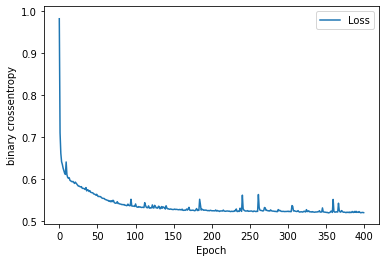


 Evaluate the neural network model against the test set:
44/44 [==============================] - 0s 3ms/step - loss: 0.5180 - accuracy: 0.7429
[0.5179763436317444, 0.7428587675094604]


In [118]:
#neural net with stats and efficiency ratings
features = []
for col in season_pred.columns:
  features.append(col)
      
features.pop(-1)
features
feature_columns = feature_columns = [tf.feature_column.numeric_column(key = key) for key in features]



my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

learning_rate = 0.0001
epochs = 400
batch_size = 800
label_name = 'Result'

# Establish the model's topography.
my_model_stats = create_model_stats(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model_stats, season_pred, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in season_test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the neural network model against the test set:")
print(my_model_stats.evaluate(x = test_features, y = test_label, batch_size=batch_size))

This will construct the probability distributions for our four models. 

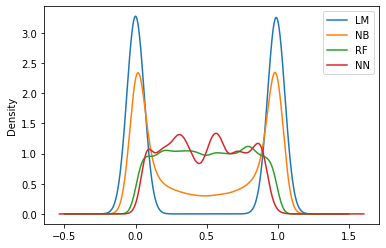

In [119]:
nn_probs = my_model_stats.predict_proba(x = test_features, batch_size=batch_size)
nn_probs = pd.DataFrame(nn_probs)
nn_probs

lm_probs = lm_probs.drop(1, axis=1).rename(columns={0 : 'LM'})
nb_probs = nb_probs.drop(1, axis=1).rename(columns={0 : 'NB'})
rf_probs = rf_probs.drop(1, axis=1).rename(columns={0 : 'RF'})
nn_probs = nn_probs.rename(columns={0 : 'NN'})


probs = pd.DataFrame()
probs['LM'] = lm_probs['LM']
probs['NB'] = nb_probs['NB']
probs['RF'] = rf_probs['RF']
probs['NN'] = nn_probs['NN']

probs.plot.kde()